# Bibliotecas e Configurações

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.api import SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')

# Objetivo

O objetivo deste projeto é ....

# Base de Dados

Comentários gerais das bases de dados

- df_dados_gerais.csv

# Transformação dos Dados

Leitura do arquivo de dados gerais para entendimento cenário global

In [4]:
df_dados_gerais = pd.read_csv('dados/dados_gerais.csv', delimiter=';', thousands='.') #parse_dates=['Ano']
df_dados_gerais

,Ano,Alunos,Bolsistas,Universitarios,Professores,Psicologos,Psicopedagogos,Psiquiatras,Assistentes_Sociais
0,2016,70,26,0,5,1,0,0,0
1,2017,300,35,0,6,1,1,0,0
2,2018,550,80,1,7,1,1,0,0
3,2019,812,106,2,9,2,1,0,0
4,2020,841,112,26,9,2,1,0,0
5,2021,824,133,51,12,2,2,0,0
6,2022,970,112,71,13,3,3,1,1
7,2023,1100,100,94,14,3,3,1,1


## Visão Geral dos Dados

In [5]:
# Criando o gráfico de colunas para alunos, bolsistas e universitários
fig1 = go.Figure()

# Adicionando colunas para alunos, bolsistas e universitários
fig1.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Alunos'], name='Alunos'))
fig1.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Bolsistas'], name='Bolsistas'))
fig1.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Universitarios'], name='Universitários'))

# Personalizando o layout do primeiro gráfico
fig1.update_layout(title='Número de Alunos, Bolsistas e Universitários ao Longo dos Anos',
                   xaxis_title='Ano',
                   yaxis_title='Número',
                   barmode='group',
                   legend_title='Grupo')

# Exibindo o primeiro gráfico
fig1.show()

# Criando o gráfico de colunas para professores, psicólogos, psicopedagogos, psiquiatras e assistentes sociais
fig2 = go.Figure()

# Adicionando colunas para professores, psicólogos, psicopedagogos, psiquiatras e assistentes sociais
fig2.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Professores'], name='Professores'))
fig2.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Psicologos'], name='Psicólogos'))
fig2.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Psicopedagogos'], name='Psicopedagogos'))
fig2.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Psiquiatras'], name='Psiquiatras'))
fig2.add_trace(go.Bar(x=df_dados_gerais['Ano'], y=df_dados_gerais['Assistentes_Sociais'], name='Assistentes Sociais'))

# Personalizando o layout do segundo gráfico
fig2.update_layout(title='Número de Professores e Profissionais de Apoio ao Longo dos Anos',
                   xaxis_title='Ano',
                   yaxis_title='Número',
                   barmode='group',
                   legend_title='Grupo')

# Exibindo o segundo gráfico
fig2.show()


In [6]:
# Adicionando colunas para a soma dos alunos e dos profissionais
df_dados_gerais['Total_Alunos'] = df_dados_gerais[['Alunos', 'Bolsistas', 'Universitarios']].sum(axis=1)
df_dados_gerais['Total_Profissionais'] = df_dados_gerais[['Professores', 'Psicologos', 'Psicopedagogos', 'Psiquiatras', 'Assistentes_Sociais']].sum(axis=1)
df_dados_gerais

,Ano,Alunos,Bolsistas,Universitarios,Professores,Psicologos,Psicopedagogos,Psiquiatras,Assistentes_Sociais,Total_Alunos,Total_Profissionais
0,2016,70,26,0,5,1,0,0,0,96,6
1,2017,300,35,0,6,1,1,0,0,335,8
2,2018,550,80,1,7,1,1,0,0,631,9
3,2019,812,106,2,9,2,1,0,0,920,12
4,2020,841,112,26,9,2,1,0,0,979,12
5,2021,824,133,51,12,2,2,0,0,1008,16
6,2022,970,112,71,13,3,3,1,1,1153,21
7,2023,1100,100,94,14,3,3,1,1,1294,22


In [7]:
# Criando o gráfico de linha para a soma dos alunos e dos profissionais ao longo dos anos
fig = go.Figure()

# Adicionando linhas para a soma dos alunos e dos profissionais
fig.add_trace(go.Scatter(x=df_dados_gerais['Ano'], y=df_dados_gerais['Total_Alunos'], mode='lines', name='Total de Alunos'))

# Adicionando uma segunda escala para os profissionais
fig.add_trace(go.Scatter(x=df_dados_gerais['Ano'], y=df_dados_gerais['Total_Profissionais'], mode='lines', name='Total de Profissionais', yaxis='y2'))

# Personalizando o layout do gráfico
fig.update_layout(title='Total de Alunos e Profissionais ao Longo dos Anos',
                  xaxis_title='Ano',
                  yaxis_title='Total de Alunos',
                  legend_title='Grupo',
                  yaxis2=dict(title='Total de Profissionais', overlaying='y', side='right'))

# Exibindo o gráfico
fig.show()

In [8]:
#TODO: Crescimento % dos alunos

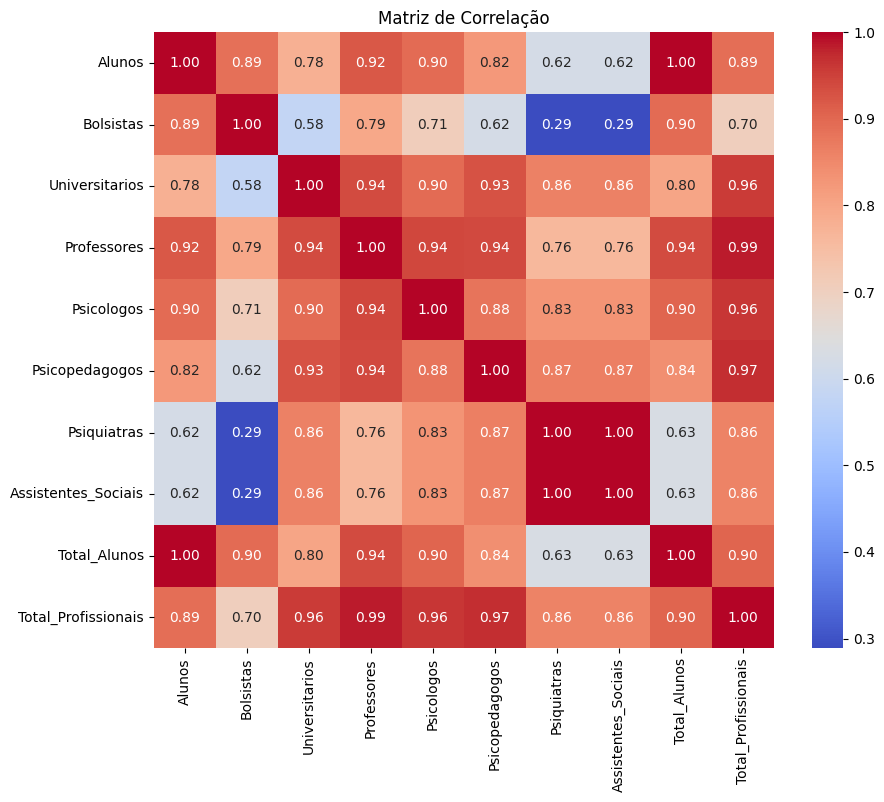

In [9]:
# Removendo a coluna de ano
df_dados_sem_ano = df_dados_gerais.drop(columns=['Ano'])

# Calculando a matriz de correlação
correlation_matrix = df_dados_sem_ano.corr()

# Criando um heatmap com Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()


# Forecast

In [10]:
# Dados existentes
anos_exist = df_dados_gerais['Ano'].values
alunos_exist = df_dados_gerais['Alunos'].values

# Previsão com média móvel simples
media_movel = np.mean(alunos_exist)
forecast_media_movel = np.full(len(anos_exist) + 5, media_movel)

# Previsão com regressão linear simples
modelo_regressao = LinearRegression()
modelo_regressao.fit(anos_exist.reshape(-1, 1), alunos_exist)
anos_futuros_regressao = np.arange(anos_exist[0], anos_exist[-1] + 6).reshape(-1, 1)
forecast_regressao = modelo_regressao.predict(anos_futuros_regressao)

# Previsão com método Naive
last_observation = alunos_exist[-1]
forecast_naive = np.full(len(anos_exist) + 5, last_observation)

# Previsão com Random Forest
modelo_random_forest = RandomForestRegressor()
modelo_random_forest.fit(anos_exist.reshape(-1, 1), alunos_exist)
anos_futuros_rf = np.arange(anos_exist[0], anos_exist[-1] + 6).reshape(-1, 1)
forecast_random_forest = modelo_random_forest.predict(anos_futuros_rf)

# Previsão com suavização exponencial simples
modelo_suav_exp = SimpleExpSmoothing(alunos_exist)
resultado_suav_exp = modelo_suav_exp.fit()
forecast_suav_exp = resultado_suav_exp.forecast(len(anos_exist) + 5)

# Criando o gráfico com Plotly
fig = go.Figure()

# Adicionando dados existentes
fig.add_trace(go.Scatter(x=anos_exist, y=alunos_exist, mode='lines+markers', name='Total de Alunos', line=dict(width=3)))

# Adicionando previsões
fig.add_trace(go.Scatter(x=anos_futuros_regressao.flatten(), y=forecast_media_movel, mode='lines', name='Média Móvel Simples', line=dict(dash='dash', width=1)))
fig.add_trace(go.Scatter(x=anos_futuros_regressao.flatten(), y=forecast_regressao, mode='lines', name='Regressão Linear Simples', line=dict(dash='dash', color='green', width=1)))
fig.add_trace(go.Scatter(x=anos_futuros_regressao.flatten(), y=forecast_naive, mode='lines', name='Método Naive', line=dict(dash='dash', width=1)))
fig.add_trace(go.Scatter(x=anos_futuros_regressao.flatten(), y=forecast_random_forest, mode='lines', name='Random Forest', line=dict(dash='dash', width=1)))
fig.add_trace(go.Scatter(x=anos_futuros_regressao.flatten(), y=forecast_suav_exp, mode='lines', name='Suavização Exponencial Simples', line=dict(dash='dash', width=1)))
# Adicione as previsões restantes aqui

# Personalizando layout
fig.update_layout(title='Previsões de Alunos desde o Início até os Próximos 5 Anos',
                  xaxis_title='Ano',
                  yaxis_title='Total de Alunos')

# Exibindo o gráfico
fig.show()


## Regressão Linear Simples

In [11]:
# Criando o gráfico com Plotly
fig = go.Figure()

# Adicionando dados existentes
fig.add_trace(go.Scatter(x=anos_exist, y=alunos_exist, mode='lines+markers', name='Dados Exist.'))

# Adicionando previsões
fig.add_trace(go.Scatter(x=anos_futuros_regressao.flatten(), y=forecast_regressao, mode='lines', name='Regressão Linear Simples', line=dict(dash='dash', color='green')))


# Personalizando layout
fig.update_layout(title='Total de Alunos + Regressão Linear Simples (5 anos)',
                  xaxis_title='Ano',
                  yaxis_title='Total de Alunos')

# Exibindo o gráfico
fig.show()

## Cenários What-if 

In [12]:
# Definindo o fator de aumento (em decimal, por exemplo, 0.1 para um aumento de 10%)
aumento = 0.5  # Isso representa um aumento de 10% TODO: receber como parâmetro no Streamlit
anos = 10

# Aplicando o aumento ao conjunto de dados original
alunos_exist_aumento = alunos_exist * (1 + aumento)

# Ajustando a regressão linear ao conjunto de dados com aumento
modelo_regressao_aumento = LinearRegression()
modelo_regressao_aumento.fit(anos_exist.reshape(-1, 1), alunos_exist_aumento)

anos_futuros_regressao = np.arange(anos_exist[0], anos_exist[-1] + anos).reshape(-1, 1) #TODO: receber como parâmetro no Streamlit o número de anos
forecast_regressao_aumento = modelo_regressao_aumento.predict(anos_futuros_regressao)

# Arredondando os valores de forecast_regressao_aumento para inteiros
forecast_regressao_aumento_int = np.round(forecast_regressao_aumento).astype(int)



# Criando o gráfico com Plotly
fig = go.Figure()

# Adicionando dados existentes
fig.add_trace(go.Scatter(x=anos_exist, y=alunos_exist, mode='lines+markers', name='Dados Exist.'))

# Adicionando previsões
fig.add_trace(go.Scatter(x=anos_futuros_regressao.flatten(), y=forecast_regressao_aumento_int, mode='lines', name='Regressão Linear Simples', line=dict(dash='dash', color='green')))


# Personalizando layout
fig.update_layout(title='Cenários de Crescimento (What-if)',
                  xaxis_title='Ano',
                  yaxis_title='Total de Alunos')

# Exibindo o gráfico
fig.show()

# Conclusão